In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import transforms as T
from torchvision import models

torch.manual_seed(0)
np.random.seed(0)

In [2]:
!gdown https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4&export=download
!unzip -qq cityscapes.zip

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4 

unzip:  cannot find or open cityscapes.zip, cityscapes.zip.zip or cityscapes.zip.ZIP.


In [3]:
!unzip -qq cityscapes.zip

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
class Segmenter(torch.nn.Module):
    def __init__(self, n_classes, encoder):
        super(Segmenter, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=n_classes, kernel_size=3, stride=1, padding=1, dilation=1)
        )
        #self.decoder = Your code for Problem 1a goes here

    def forward(self, x):
      x1 = self.encoder(x)
      x2 = self.decoder(x1)
      return x2 # Your code for Problem 1a goes here

In [6]:
class CityScapesDataset(Dataset):
  def __init__(self, images, labels, im_transform, mask_transform):
    self.images = images
    self.labels = labels
    self.im_transform = im_transform
    self.mask_transform = mask_transform
  
  def __getitem__(self, idx):
    im = Image.open(self.images[idx])
    mask = Image.open(self.labels[idx])
    im = self.im_transform(im)[0:3, ...] # Transform image

    # Add an extra first dimension to mask, needed for transforms, convert
    # to LongTensor, and apply transforms to mask.
    mask = np.asarray(mask)[None, ...] 
    mask = torch.LongTensor(mask)
    mask = self.mask_transform(mask)

    # Apply random horizontal flip to image and mask
    if np.random.rand() > 0.5:
      im = TF.hflip(im)
      mask  = TF.hflip(mask)

    return im, mask

  def __len__(self):
    return len(self.images)

In [7]:
batch_size = 16

# Make image and mask transforms.
im_transform = [T.ToTensor()]
im_transform.append(T.Resize((256, 256), interpolation=T.InterpolationMode.BILINEAR))
im_transform = T.Compose(im_transform)

mask_transform = T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)

def get_dataloader(im_path):
  images = sorted(glob.glob(im_path + '/*8bit.jpg'))
  labels = sorted(glob.glob(im_path + '/*labelIds.png'))   
  dataset = CityScapesDataset(images, labels, im_transform, mask_transform)
  return data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

# Create dataloaders
train_dataloader = get_dataloader('./cityscapes/train')
val_dataloader = get_dataloader('./cityscapes/val')

In [8]:
# Get features from VGG16 up through 3 downsampling (maxpool) operations.
vgg = models.vgg16(pretrained=True);
encoder = nn.Sequential(*(list(vgg.children())[:1])[0][0:17]);

# Create model
n_classes = 34
model = Segmenter(n_classes, encoder)
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 240MB/s]


Segmenter(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [9]:
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 7

model.train()
for epoch in range(num_epochs):
  for batch, (X,y) in enumerate(train_dataloader):

    X = X.to(device)
    y = y.squeeze(1).to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 20 == 0:
      print(epoch, batch, loss.item())

  torch.save(model.state_dict(), 'model_%d.params' % epoch)

# Problem 1b: Your training loop code goes here

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0 0 3.546656608581543
0 20 2.0381975173950195
0 40 1.4624985456466675
0 60 1.171456217765808
0 80 0.8304290771484375
0 100 0.9717810153961182
0 120 0.7550914287567139
0 140 0.6820117235183716
0 160 0.8044037818908691
0 180 0.6857491731643677


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1 0 0.8933160901069641
1 20 0.8024747967720032
1 40 0.8018503785133362
1 60 0.8840116262435913
1 80 0.732154369354248
1 100 0.6281993389129639
1 120 0.6843209266662598
1 140 0.6008503437042236
1 160 0.6536865234375
1 180 0.780336320400238


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2 0 0.7569032311439514
2 20 0.7525769472122192
2 40 0.789995014667511
2 60 0.5603728890419006
2 80 0.5451592803001404
2 100 0.6750185489654541
2 120 0.5753572583198547
2 140 0.6073604822158813
2 160 0.5860581994056702
2 180 0.6138862371444702


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


3 0 0.6030255556106567
3 20 0.6318972110748291
3 40 0.625010073184967
3 60 0.5566516518592834
3 80 0.5735636949539185
3 100 0.6764300465583801
3 120 0.5848569869995117
3 140 0.6042382717132568
3 160 0.6028289198875427
3 180 0.707490086555481


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


4 0 0.5298854112625122
4 20 0.6201655864715576
4 40 0.5760781168937683
4 60 0.6950218081474304
4 80 0.6362650990486145
4 100 0.44218045473098755
4 120 0.755675196647644
4 140 0.54273521900177
4 160 0.538612425327301
4 180 0.6677025556564331


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


5 0 0.6670325994491577
5 20 0.6030889749526978
5 40 0.5157409906387329
5 60 0.515414834022522
5 80 0.5304893851280212
5 100 0.5432601571083069
5 120 0.5393878817558289
5 140 0.4809800088405609
5 160 0.6114009022712708
5 180 0.6231175661087036


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


6 0 0.5699867606163025
6 20 0.4760593771934509
6 40 0.5677265524864197
6 60 0.6489722728729248
6 80 0.5169224739074707
6 100 0.5029163956642151
6 120 0.4709210693836212
6 140 0.5454525947570801
6 160 0.6174253225326538
6 180 0.6155321002006531


In [13]:
# Problem 1c: Your IoU evaluation code goes here

model.load_state_dict(torch.load('model_6.params', map_location=torch.device('cpu')))
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

batch_size = 16
iou_array = np.array([])

with torch.no_grad():
    for batch, (X, y) in enumerate(val_dataloader):
        X, y = X.to(device), y.to(device)

        outputs = model(X)

        outputs1 = outputs.cpu()
        y1 = y.cpu()

        iou = []

        for c in range(n_classes):
          intersection = np.logical_and(y1, outputs1[:,c,:,:]).sum().item()
          union = np.logical_or(y1, outputs1[:,c,:,:]).sum().item()
          iou_c = intersection /union
          iou.append(iou_c)
        
        if iou_array.size == 0:
          iou_array = np.array(iou)
        else:
          iou_ay = np.array(iou)
          iou_array = np.vstack((iou_array, iou_ay))


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:
print(np.mean(iou_array,axis=0))

[0.99965069 0.99965069 0.99965069 0.99965069 0.99965069 0.99965069
 0.99965069 0.99965069 0.99965069 0.99965069 0.99965069 0.99965069
 0.99965069 0.99965069 0.99965069 0.99965069 0.99965069 0.99965069
 0.99965069 0.99965069 0.99965069 0.99965066 0.99965069 0.99965069
 0.99965069 0.99965069 0.99965069 0.99965069 0.99965069 0.99965069
 0.99965069 0.99965069 0.99965069 0.99965069]


In [15]:
print(iou_array)

[[0.99999523 0.99999523 0.99999523 ... 0.99999523 0.99999523 0.99999523]
 [0.99997711 0.99997711 0.99997711 ... 0.99997711 0.99997711 0.99997711]
 [0.99999809 0.99999809 0.99999809 ... 0.99999809 0.99999809 0.99999809]
 ...
 [0.99999714 0.99999714 0.99999714 ... 0.99999714 0.99999714 0.99999714]
 [0.99998856 0.99998856 0.99998856 ... 0.99998856 0.99998856 0.99998856]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [17]:
print(np.mean(iou_array,axis=1))

[0.99999523 0.99997708 0.99999809 0.99998188 0.99998951 0.99999905
 0.99997234 1.         0.99999142 0.99999809 0.99999428 0.99872875
 0.99986076 1.         0.99989414 0.99995136 0.99685192 0.99999809
 0.99999905 0.99999714 0.99999619 0.99999046 0.99456501 0.9999876
 0.99997997 0.99999619 0.99998569 0.99917889 0.99997807 0.99999714
 0.99998856 1.        ]


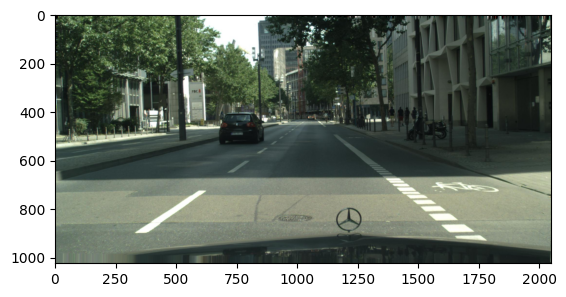

In [21]:
# Problem 1d: Your image results code goes here
image = Image.open('/content/cityscapes/val/frankfurt_000000_015389_leftImg8bit.jpg')
plt.imshow(image)

In [113]:
  im_path = './cityscapes/val'
  images = sorted(glob.glob(im_path + '/*8bit.jpg'))
  labels = sorted(glob.glob(im_path + '/*labelIds.png'))   
  val_dataset = CityScapesDataset(images, labels, im_transform, mask_transform)

In [118]:
import os
import torch
import torchvision.transforms as transforms
import cv2

filename = "./cityscapes/val/frankfurt_000000_015389_leftImg8bit.jpg"

for i, (image, label) in enumerate(val_dataset):
    if os.path.basename(val_dataset.images[i]) == os.path.basename(filename):
        index = i
        break

image, label = val_dataset[index]
image_np = image.permute(1, 2, 0)
label_np = label.permute(1, 2, 0)


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

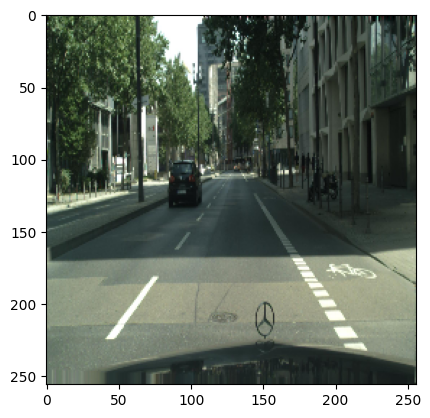

True

In [120]:
plt.imshow(image_np)
plt.show()

image_array = (image_np.numpy() * 255).astype(np.uint8)
cv2.imwrite('i-0.jpg', image_array)

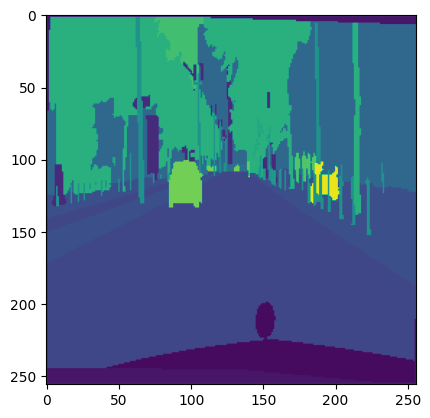

True

In [121]:
plt.imshow(label_np)
plt.show()

image_array = (label_np.numpy() * 255).astype(np.uint8)
cv2.imwrite('i-1.jpg', image_array)

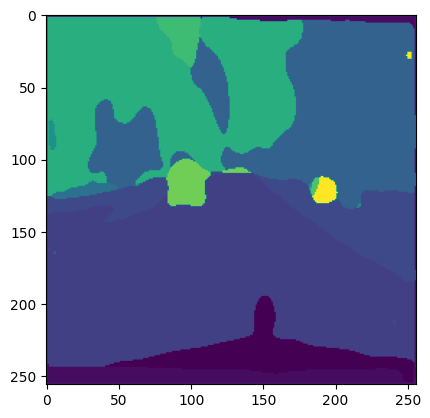

True

In [123]:
model.load_state_dict(torch.load('model_6.params', map_location=torch.device('cpu')))
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

img = image.unsqueeze(0)

img = img.to(device)

predict = model(img)

segentation_pred = predict.argmax(1).squeeze().detach().cpu().numpy()

plt.imshow(segentation_pred)
plt.show()

image_array = (segentation_pred * 255).astype(np.uint8)
cv2.imwrite('i-2.jpg', image_array)

In [124]:
filename = "./cityscapes/val/frankfurt_000001_057954_leftImg8bit.jpg"

for i, (image, label) in enumerate(val_dataset):
    if os.path.basename(val_dataset.images[i]) == os.path.basename(filename):
        index = i
        break

image, label = val_dataset[index]
image_np = image.permute(1, 2, 0)
label_np = label.permute(1, 2, 0)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

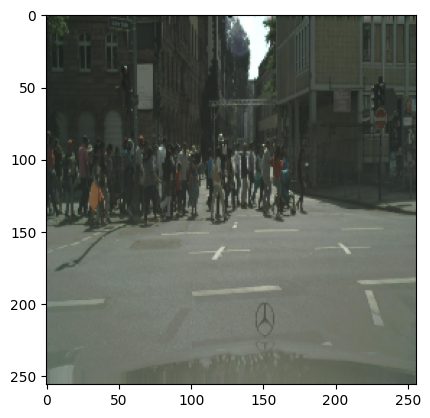

True

In [125]:
plt.imshow(image_np)
plt.show()

image_array = (image_np.numpy() * 255).astype(np.uint8)
cv2.imwrite('ii-0.jpg', image_array)

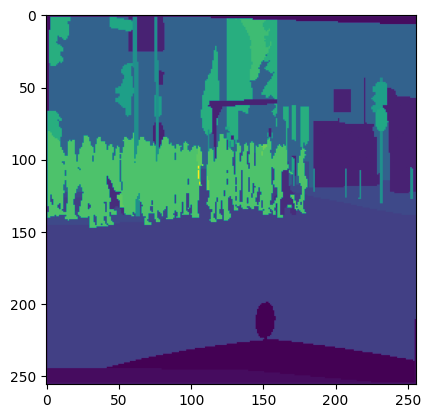

True

In [126]:
plt.imshow(label_np)
plt.show()

image_array = (label_np.numpy() * 255).astype(np.uint8)
cv2.imwrite('ii-1.jpg', image_array)

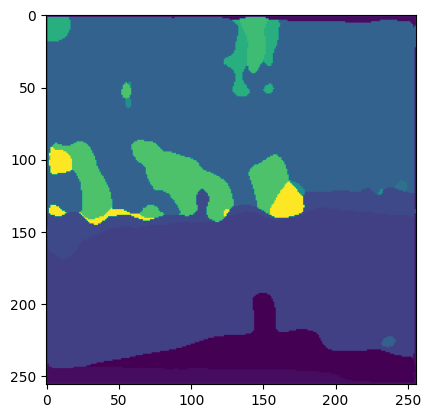

True

In [127]:
model.load_state_dict(torch.load('model_6.params', map_location=torch.device('cpu')))
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

img = image.unsqueeze(0)

img = img.to(device)

predict = model(img)

segentation_pred = predict.argmax(1).squeeze().detach().cpu().numpy()

plt.imshow(segentation_pred)
plt.show()

image_array = (segentation_pred * 255).astype(np.uint8)
cv2.imwrite('ii-2.jpg', image_array)

In [128]:
filename = "./cityscapes/val/lindau_000037_000019_leftImg8bit.jpg"

for i, (image, label) in enumerate(val_dataset):
    if os.path.basename(val_dataset.images[i]) == os.path.basename(filename):
        index = i
        break

image, label = val_dataset[index]
image_np = image.permute(1, 2, 0)
label_np = label.permute(1, 2, 0)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

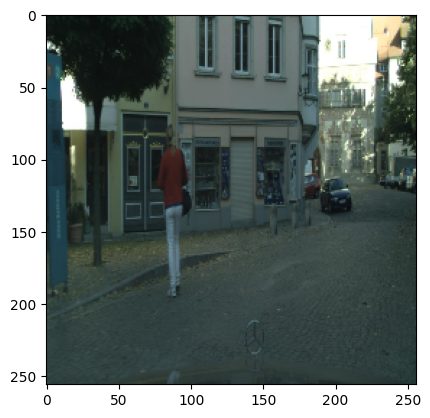

True

In [129]:
plt.imshow(image_np)
plt.show()

image_array = (image_np.numpy() * 255).astype(np.uint8)
cv2.imwrite('iii-0.jpg', image_array)

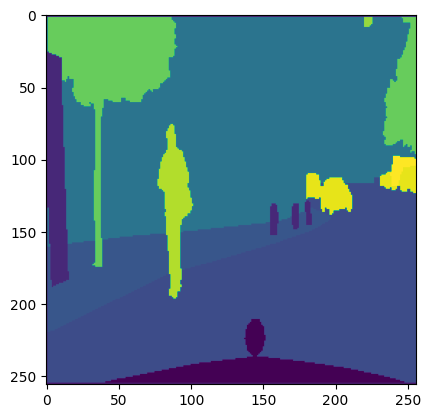

True

In [130]:
plt.imshow(label_np)
plt.show()

image_array = (label_np.numpy() * 255).astype(np.uint8)
cv2.imwrite('iii-1.jpg', image_array)

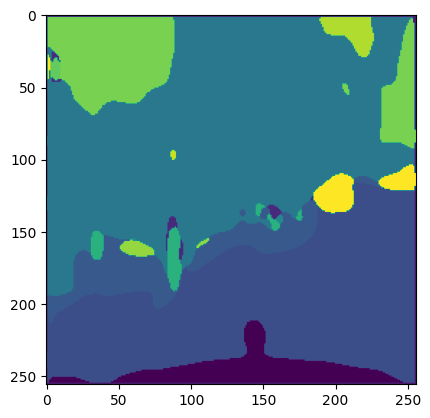

True

In [131]:
model.load_state_dict(torch.load('model_6.params', map_location=torch.device('cpu')))
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

img = image.unsqueeze(0)

img = img.to(device)

predict = model(img)

segentation_pred = predict.argmax(1).squeeze().detach().cpu().numpy()

plt.imshow(segentation_pred)
plt.show()

image_array = (segentation_pred * 255).astype(np.uint8)
cv2.imwrite('iii-2.jpg', image_array)

In [132]:
filename = "./cityscapes/val/munster_000173_000019_leftImg8bit.jpg"

for i, (image, label) in enumerate(val_dataset):
    if os.path.basename(val_dataset.images[i]) == os.path.basename(filename):
        index = i
        break

image, label = val_dataset[index]
image_np = image.permute(1, 2, 0)
label_np = label.permute(1, 2, 0)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

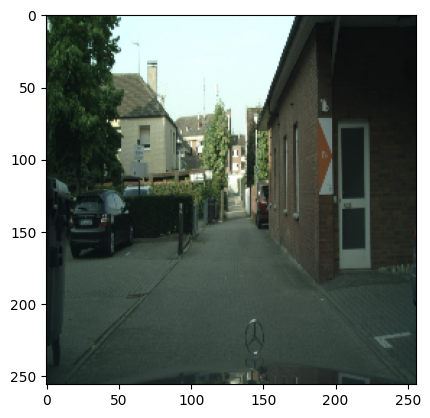

True

In [133]:
plt.imshow(image_np)
plt.show()

image_array = (image_np.numpy() * 255).astype(np.uint8)
cv2.imwrite('iv-0.jpg', image_array)

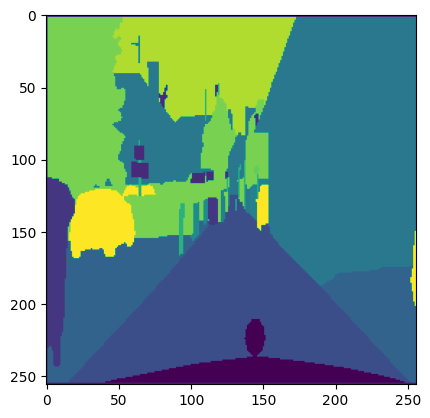

True

In [134]:
plt.imshow(label_np)
plt.show()

image_array = (label_np.numpy() * 255).astype(np.uint8)
cv2.imwrite('iv-1.jpg', image_array)

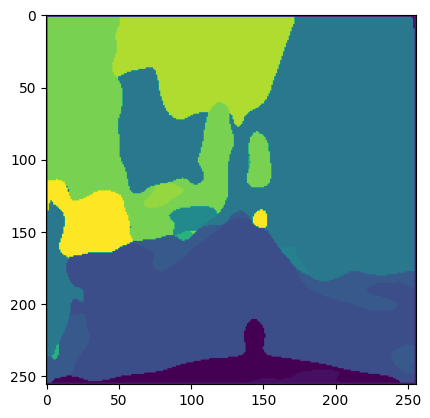

True

In [135]:
model.load_state_dict(torch.load('model_6.params', map_location=torch.device('cpu')))
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

img = image.unsqueeze(0)

img = img.to(device)

predict = model(img)

segentation_pred = predict.argmax(1).squeeze().detach().cpu().numpy()

plt.imshow(segentation_pred)
plt.show()

image_array = (segentation_pred * 255).astype(np.uint8)
cv2.imwrite('iv-2.jpg', image_array)